Using SVM with a shifting temporal window to look for changes in trends that get accepted to Nature or Science.

Starting with just atom-ph, and comparing PR vs Nature

In [1]:
#Need to add parent directoy to sys.path to find 'metadataDB'
import sys
sys.path.append('../../../')

%matplotlib inline
import matplotlib.pyplot as plt 
import time
import numpy as np
import re
from itertools import combinations
import json

# Natural language processing toolkit
# To use this, run nltk.download() and download 'stopwords'
# from nltk.corpus import stopwords
# s=stopwords.words('english') + ['']

# Machine learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib

# SQL
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from metadataDB.declareDatabase import *
from sqlalchemy import or_, and_

from datetime import date

import json
import pickle

engine = create_engine("sqlite:///../../../arXiv_metadata.db", echo=False)
Base.metadata.bind = engine
DBsession = sessionmaker(bind=engine)
session = DBsession()

In [2]:
journals_dict = {'PRL': ['Physics Review Letters%',
                    'Phys. Rev. Lett.%',
                    'Phys.Rev.Lett.%',
                    'PRL%'],
                 'PR':  ['Physics Review%',
                         'Phys. Rev.%',
                         'Phys.Rev.%',
                         'PR%'],
                 'Nature': ['Nature%',
                            'Nat.%',
                            'Science%'],
                 'APL': ['APL%',
                         'Appl.Phys.Lett.%',
                         'Appl. Phys. Lett.%',
                         'Applied Physics Letters%'],
                 'AP': ['AP%',
                        'Appl.Phys.%',
                        'Appl. Phys.%',
                        'Applied Physics%'],
                 'PL': ['Physics Letters%',
                        'Phys. Lett.%',
                        'Phys.Lett.%'],
                 'All': ['%'],
                 }


In [3]:
def get_abstracts(journal, date_first, date_last):
#     query = session.query(Article)\
#                     .filter(*[Article.journal_ref.like(x) for x in journals_dict[journal]])
    query = session.query(Article_Category)\
                    .join(Category)\
                    .join(Article)\
                    .filter(Article.created >= date_first,
                            Article.created < date_last,
                            or_(*[Article.journal_ref.like(x) for x in journals_dict[journal]]))
    # Don't need to clean up text: CountVectorizer will do everything
    return [ result.article.abstract for result in query ]


def learn(journals, date_first, date_last):
    abstracts1 = get_abstracts(journals[0], date_first, date_last)
    abstracts2 = get_abstracts(journals[1], date_first, date_last)
    
    half_test_size = int(round(0.1*min(len(abstracts1),len(abstracts2))))


    X1_train, X1_test, y1_train, y1_test = train_test_split(abstracts1, [0]*len(abstracts1), test_size=half_test_size, random_state=42)
    X2_train, X2_test, y2_train, y2_test = train_test_split(abstracts2, [1]*len(abstracts2), test_size=half_test_size, random_state=42)
    
    X_train = X1_train + X2_train
    X_test = X1_test + X2_test
    y_train = np.array(y1_train + y2_train)
    y_test = np.array(y1_test + y2_test)
    target_names = journals
    
    print (len(X1_train), len(X2_train))
    
    # Using a large C (overfitting) to generate a greater number of nonzero coefficients
    # Remember, L1 norms suppress the number of nonzero coefficients
    
    clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,3),stop_words='english')),
                    ('tfidf', TfidfTransformer()),
                    ('clf', LinearSVC(C=1000,penalty='l1',dual=False,fit_intercept=True))])
    
    try:
        clf.fit(X_train, y_train)
    except ValueError:
        return {}
#     y_predict_train = clf.predict(X_train)
    y_predict_test = clf.predict(X_test)
    
#     # To save memory, I will retrain the countvectorizer on only the nonzero entries to the coefficient matrix.
    
#     nonzero_coefs = np.nonzero(np.squeeze(clf.named_steps['clf'].coef_))
#     useful_words = np.array(clf.named_steps['vect'].get_feature_names())[nonzero_coefs]
    
#     clf2 = Pipeline([('vect', CountVectorizer(ngram_range=(1,3),stop_words='english',vocabulary=useful_words)),
#                     ('tfidf', TfidfTransformer()),
#                     ('clf', LinearSVC(C=10,penalty='l1',dual=False,fit_intercept=True))])
#     clf2.fit(X_train, y_train)
#     y_predict_test2 = clf2.predict(X_test)
    
#     print 'Full model'
#     print (metrics.classification_report(y_test, y_predict_test,
#                                     target_names=target_names))

#     print metrics.confusion_matrix(y_test, y_predict_test)
#     print 'Accuracy: %f' % (metrics.accuracy_score(y_test, y_predict_test))
    
#     print ''
#     print 'Reduced model'
#     print (metrics.classification_report(y_test, y_predict_test2,
#                                     target_names=target_names))

#     print metrics.confusion_matrix(y_test, y_predict_test2)
#     print 'Accuracy: %f' % (metrics.accuracy_score(y_test, y_predict_test2))
    
#     return (clf, clf2)
    return clf

def most_important_keywords(clf, num=50):
    """Prints features with the highest coefficient values, per class"""
    feature_names = clf.named_steps['vect'].get_feature_names()
#     for i, class_label in enumerate(class_labels):
#     top = [feature_names[x] for x in np.argsort(clf.named_steps['clf'].coef_[0])[-num:]][::-1]
    ind = np.nonzero(clf.named_steps['clf'].coef_[0])[0]
#     print ind
    return {feature_names[x]: clf.named_steps['clf'].coef_[0][x] for x in ind}

#     print(" ".join(feature_names[j] for j in top10))

In [4]:
# 6 month window, shifting one month at a time
date_list = [ date(x, y, 1) for x in range(2000, 2016) for y in range(1,12,1) ] + [date(2016,1,1)]
window_size = 6
journals = ['PR', 'Nature']

keywords = {}

date_list = date_list

for x,y in zip(date_list[:-window_size],date_list[window_size:]):
    start = time.time()
    print x, y
    try:
        clf = learn(journals, x, y)
        keywords[x] = most_important_keywords(clf)
        print time.time() - start
    except ValueError:
        pass
        
# #     break

# # abstracts = get_abstracts('Nature', date(2000,1,1), date(2016,1,1))

2000-01-01 2000-07-01
(978, 15)
7.66416478157
2000-02-01 2000-08-01
(1015, 17)
5.44859099388
2000-03-01 2000-09-01
(1092, 17)
5.5670800209
2000-04-01 2000-10-01
(1071, 19)
7.26853704453
2000-05-01 2000-11-01
(1121, 17)
5.84052610397
2000-06-01 2001-01-01
(1330, 27)
6.02110600471
2000-07-01 2001-02-01
(1518, 27)
6.33211398125
2000-08-01 2001-03-01
(1649, 35)
6.4934399128
2000-09-01 2001-04-01
(1819, 40)
6.8575501442
2000-10-01 2001-05-01
(2038, 45)
7.18349909782
2000-11-01 2001-06-01
(2289, 48)
7.71435904503
2001-01-01 2001-07-01
(2393, 40)
7.77502703667
2001-02-01 2001-08-01
(2475, 43)
7.93215799332
2001-03-01 2001-09-01
(2509, 36)
8.03805303574
2001-04-01 2001-10-01
(2457, 37)
7.86434197426
2001-05-01 2001-11-01
(2456, 34)
8.06600213051
2001-06-01 2002-01-01
(2718, 38)
8.30753493309
2001-07-01 2002-02-01
(2636, 42)
8.16750001907
2001-08-01 2002-03-01
(2560, 39)
8.10741400719
2001-09-01 2002-04-01
(2638, 39)
8.19429993629
2001-10-01 2002-05-01
(2705, 38)
8.18939185143
2001-11-01 2002-0

In [5]:
with open("predict_journal_drift1", "w") as f:
    pickle.dump(keywords, f)

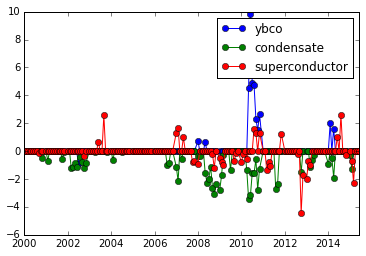

In [6]:
# I should use CountVectorizer for this. Oh well.

def extract_word(word):
    t = []
    coef = []
    for x, y in keywords.iteritems():
        try:
            coef.append(y[word])
        except KeyError:
            coef.append(0)
        t.append(x)
    ind = np.argsort(t)
    
#         print coef
#     print time
    return (np.array(t)[ind], np.array(coef)[ind])


words = ['ybco', 'condensate', 'superconductor']
for word in words:
    t, coef = extract_word(word)
    plt.plot(t, coef, 'o-', label=word)
plt.legend()

In [7]:
# Find most common words, weighted by the absolute value of their coefficient

all_words_dict = {}
for x in keywords.itervalues():
    for word, coef in x.iteritems():
        try:
            all_words_dict[word] += np.abs(coef)
        except KeyError:
            all_words_dict[word] = np.abs(coef)

all_words = sorted(all_words_dict.items(), key=lambda x: -x[1])

print ', '.join([x[0] for x in all_words[:40]])


study, model, discuss, consider, propose, investigate, present, results, paper, shown, using, theory, galaxies, case, discovery, data, investigated, discussed, calculations, method, terms, analysis, studied, decay, planet, energy, behavior, different, phys, scheme, non, simulations, obtained, field, time, calculate, function, general, photonics, research


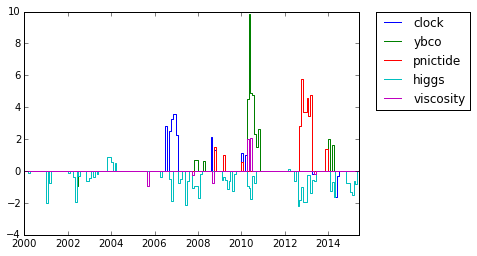

In [8]:
words = ['clock', 'ybco', 'pnictide', 'higgs', 'viscosity']
# for word in all_words[0:10]:
for word in words:
    t, coef = extract_word(word)
    plt.step(t, coef, '-', label=word)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

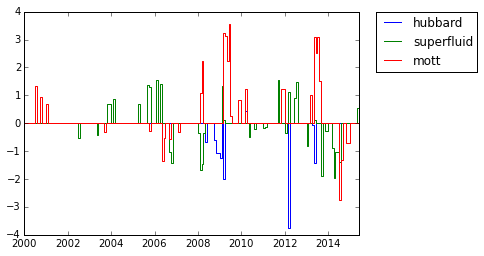

In [9]:
# words = ['clock', 'ybco', 'pnictide', 'higgs', 'viscosity']
# words = ['BCS', 'clock', 'ybco', 'pnictide', 'higgs', 'spin orbit']
words = ['hubbard', 'superfluid', 'mott']
# for word in all_words[0:10]:
for word in words:
    t, coef = extract_word(word)
    plt.step(t, coef, '-', label=word)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)